In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

df = pd.read_csv('dataset_fix.csv')

In [19]:
import pandas as pd

df = df.dropna(subset=['komentar_bersih', 'label_sentimen'])


df['komentar_bersih'] = df['komentar_bersih'].astype(str)


label_map = {'negatif': 0, 'netral': 1, 'positif': 2}
df['label_sentimen'] = df['label_sentimen'].map(label_map)


df = df[df['label_sentimen'].isin([0, 1, 2])]

print(df['label_sentimen'].value_counts())  
print(df['label_sentimen'].unique())


label_sentimen
1.0    786
2.0    540
0.0    233
Name: count, dtype: int64
[1. 2. 0.]


In [20]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df['komentar_bersih'])

sequences = tokenizer.texts_to_sequences(df['komentar_bersih'])
max_len = 50  # optimal berdasarkan distribusi panjang

X = pad_sequences(sequences, maxlen=max_len, padding='post')

In [21]:
le = LabelEncoder()
y = le.fit_transform(df['label_sentimen'])
y = to_categorical(y, num_classes=3)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [23]:


model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_len))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

c:\Users\Asus\Downloads\Folder HD\UAS2\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [24]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop]) 

Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.4805 - loss: 1.0345 - val_accuracy: 0.5032 - val_loss: 0.9615
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.5679 - loss: 0.9232 - val_accuracy: 0.6827 - val_loss: 0.7234
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.7755 - loss: 0.5650 - val_accuracy: 0.7276 - val_loss: 0.6696
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8810 - loss: 0.4083 - val_accuracy: 0.8269 - val_loss: 0.4980
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.9676 - loss: 0.1248 - val_accuracy: 0.7724 - val_loss: 0.5653
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9845 - loss: 0.0786 - val_accuracy: 0.8013 - val_loss: 0.6246
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9947 - loss: 0.0316 - val_accuracy: 0.8109 - val_loss: 0.6811


In [25]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Akurasi Model: {accuracy * 100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8504 - loss: 0.4514
Akurasi Model: 82.69%


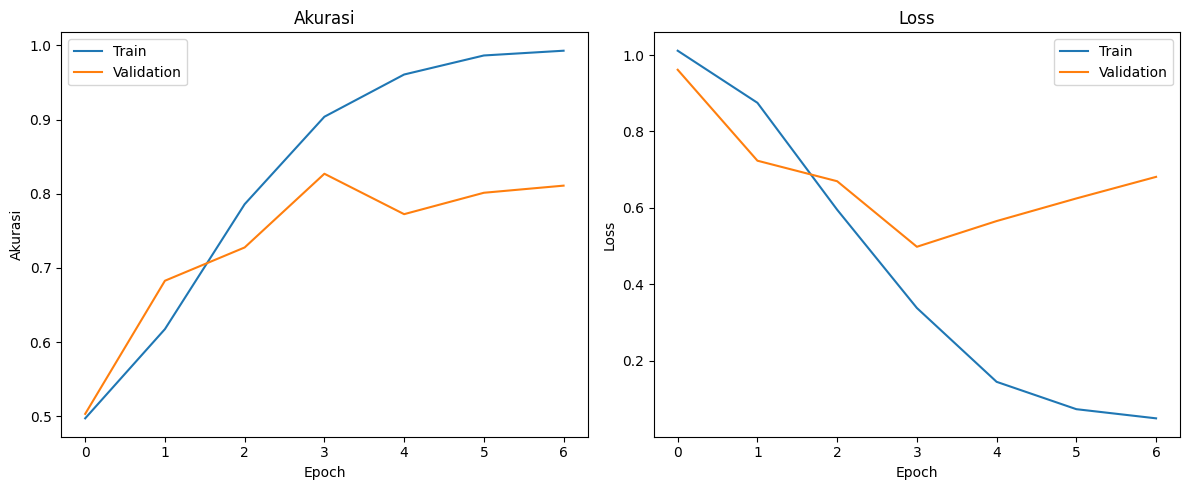

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig("model/output_LSTM.png")
plt.show()


In [27]:
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.models import load_model

In [28]:
model.save("model/model_LSTM.h5")

In [29]:
with open("model/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [30]:
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_test.argmax(axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


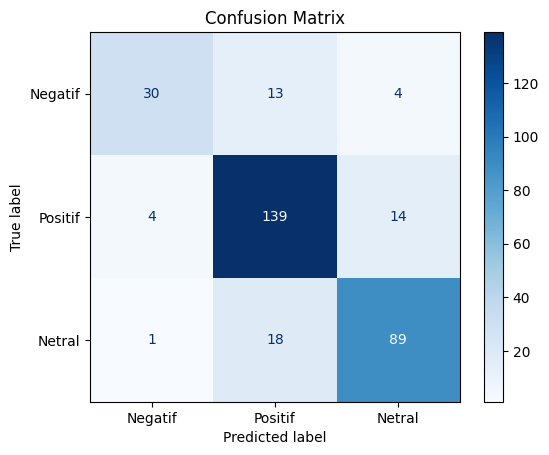

In [31]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatif', 'Positif', 'Netral'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("model/Confusion Matrix_LSTM.png")
plt.show()


In [34]:
print("Evaluasi Per Kelas:")
print(classification_report(y_true, y_pred, target_names=['Negatif', 'Positif', 'Netral']))
print(f"Akurasi Model LSTM: {accuracy * 100:.2f}%")

Evaluasi Per Kelas:
              precision    recall  f1-score   support

     Negatif       0.86      0.64      0.73        47
     Positif       0.82      0.89      0.85       157
      Netral       0.83      0.82      0.83       108

    accuracy                           0.83       312
   macro avg       0.84      0.78      0.80       312
weighted avg       0.83      0.83      0.82       312

Akurasi Model LSTM: 82.69%


<Axes: xlabel='label_sentimen', ylabel='count'>

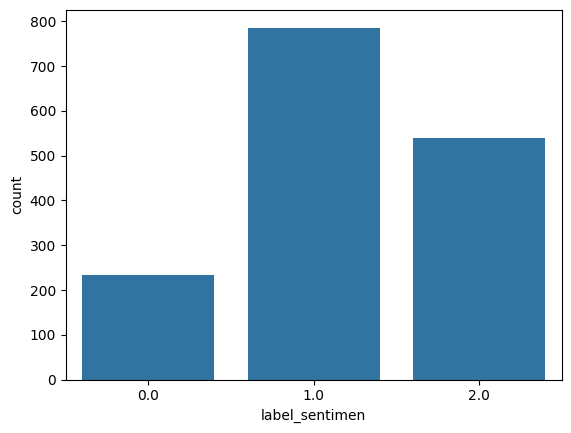

In [33]:
import seaborn as sns
sns.countplot(x='label_sentimen', data=df)